# Dataset: Amazon Food Reviews
This exercise will involve analyzing a dataset of user reviews of food items from Amazon.com. Originally, over 568,000 reviews were collected between 1999 and 2012. For the sake of computational ease, the current dataset has been decimated to 56,846 observations. The dataset is split between two files: *scores.txt*, which documents the user rating given to an item, and *reviews.txt*, which contains the text-based review left by the user. In both files, observations are split by line. In this exercise, we will perform simplified sentiment analysis, exploring which tokens are predictive of a low rating (1 Star) and a high rating (5 stars). 

# Section 1: Text Processing
In this section, you will write a text processing pipeline will iteratively read in the Amazon reviews, line-by-line, from *reviews.txt*, perform a series of cleaning steps, and save them into a new file, *reviews_tokenized.txt*. There is no one right text processing pipeline, and decisions to include or exclude certain processing steps should be made based on the corpus. Construct your own text processing pipeline below, and experiment with including certain features (e.g. piped-stemming via POS-tagging, spellcheck and correcting spelling, inclusion/exclusion of numbers). Document your decision making, and see the Module 4 Solutions notebook for guidance/inspiration.

**NOTE:** Depending on the complexity of your pipeline, writing to file may take a while. Sam's pipeline took approximately **10 minutes** to complete. For the impatient, feel free to use the pre-tokenized file and continue with the exercises.

In [ ]:
import os, codecs, nltk, re, enchant
import numpy as np
from difflib import SequenceMatcher
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

## Define path for NLTK to search for tokenizer information.
nltk.data.path.append(os.path.abspath('nltk_data'))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Initialize functions. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## See below for notes.

## Convenience functions.
to_lower = np.vectorize(lambda s: s.lower())

has_numbers = np.vectorize(lambda s: bool(re.search(r'\d', s)))

def similar(a,b):
    return SequenceMatcher(None, a, b).ratio()

## Word tokenizer.
pattern = '[\w]+'    
tokenizer = RegexpTokenizer(pattern)

## Initialize spellchecker.
spellcheck = enchant.Dict('en_US')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Open files.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Open reviews/reviews_tokenized files.
reviews = codecs.open(os.path.join('amazon', 'reviews.txt'),'r')
reviews_tokenized = codecs.open(os.path.join('amazon','reviews_tokenized.txt'),'w')

## Load scores.
scores = np.loadtxt(os.path.join('amazon','scores.txt'))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
ENGLISH_STOP_WORDS = list(ENGLISH_STOP_WORDS)

## Main loop.
for n, line in enumerate(reviews.readlines()):

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Tokenization + Parts-of-Speech Tagging.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ## After inspecting several dozen entries, it seemed 
    ## to me that many of the comments followed a reasonably
    ## proper grammar, such that position-of-speech tagging
    ## was possible and therefore helpful. 
    ##
    ## Including POS-tagging requires lines to be sentence-tokenized
    ## first.
    
    ## Setence tokenization.
    sentences = sent_tokenize(line.strip())
    
    ## Word tokenization.
    sentences = [tokenizer.tokenize(sentence) for sentence in sentences]
    
    ## Parts-of-speech tagging.
    ## I included the "if sentence" at the end of the list 
    ## comprehension below to handle corner cases where,
    ## after word tokenizing, there are no tokens left
    ## in a sentence. Empty lists are equivalent to 
    ## False statements in python. 
    tokens_tags = np.vstack([nltk.pos_tag(sentence) for sentence in sentences if sentence])

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Stop words.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ## Same as before, I remove the standard English
    ## stopwords using the list compiled by Scikit-Learn.
    ## I also remove any tokens less than 3 characters in 
    ## length, as well as any proper nouns or tokens
    ## containing numeric characters.
    
    ## Lowercase all tokens.
    tokens_tags = np.apply_along_axis(to_lower, 0, tokens_tags)
    
    ## Apply Scikit-Learn stopwords.
    tokens_tags = tokens_tags[~np.in1d(tokens_tags[:,0], ENGLISH_STOP_WORDS)]

    ## Remove all proper nouns.
    tokens_tags = tokens_tags[~np.in1d(tokens_tags[:,1], ['nnp','nnps'])]
    
    ## Remove all tokens less than 3 characters in length.
    tokens_tags = tokens_tags[[False if len(token) < 3 else True for token in tokens_tags[:,0]]]
    
    ## Remove all tokens with numeric characters.
    if len(tokens_tags):
        tokens_tags = tokens_tags[~np.apply_along_axis(has_numbers, 0, tokens_tags[:,0])]
    
    ## Skip if no tokens. Delete corresponding score.
    if len(tokens_tags) < 1:
        scores = np.delete(scores, n)
        continue
        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Stemming + Lemmatizing.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#    
    ## I will pass on the stemming/lemmatizing. My a priori
    ## hunch is that adjectives/adverbs will play a larger
    ## role in predicting score than will nouns/verbs.
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Spellcheck + Spelling Correction.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#   
    ## Though this is probably not wise, I implemented
    ## an automatic incorrect-spelling fixer for example's
    ## sake. Because this is the internet, I assume
    ## there will be more spelling mistakes than in the NSF
    ## example and it may be helpful. 
    ##
    ## One big problem I stumbled across is handling contractions.
    ## For a discussion of some ways to handle contractions,
    ## please see: 
    ## https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
    ## 
    ## As a heuristic attempt to fix this issue, I use a dictionary
    ## to manually replace certain tokens.
    
    ## Define contractions.
    contraction_dict = dict(didn = "didnt", couldn = "couldnt", isn = "isnt", wasn = "wasnt",
                            wouldn = "wouldnt", don = "dont", doesn = "doesnt")
    
    ## Limit to tokens.
    tokens = tokens_tags[:,0]
    
    for i, token in enumerate(tokens):
        
        token = str(token)
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Fixing contractions.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
        if token in contraction_dict.keys():
            
            replacement = contraction_dict[token]
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Fixing spelling mistakes.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

        elif not spellcheck.check(token):
                            
            ## Get list of suggestions.
            suggestions = spellcheck.suggest(token)

            ## If no suggestsions given...
            if not suggestions:
                tokens[i] = ''
                continue

            ## Find index of maximally similar word.
            replace_ix = np.argmax([similar(token,suggestion) for suggestion in suggestions])

            ## This section of code is clunky and deserves explanation.
            ## There are situations where the spellchecker returns two words.
            ## This is problematic insofar that many of these two word
            ## pairs are comprised of strings less than 3 characters long.
            ## This list comprehension makes sure only strings greater than
            ## 2 characters are allowed. This has the happy byproduct that
            ## an empty list (i.e. no strings greater than 2 characters)
            ## becomes a non-space, "", when joined. 
            replacement = ' '.join([s for s in suggestions[replace_ix].split() if len(s) > 2])
       
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Fixing spelling mistakes.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
        else:
            
            replacement = token
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Store replacement.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# 
        
        tokens[i] = replacement

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Write tokens to file.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Convert to line.
    line = ' '.join(tokens) + '\n'
    
    ## Final check: If line is only whitespace, do 
    ## not write line to file and delete corresponding
    ## review. Otherwise, write line to file.
    if line.isspace():
        scores = np.delete(scores, n)
    else:
        reviews_tokenized.write( line )
            
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Close and save files.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Close text files.
reviews.close()
reviews_tokenized.close()

## Save scores.
np.savetxt(os.path.join('amazon','scores_tokenized.txt'), scores, fmt='%s')

print('Done.')

# Section 2: Sentiment Analysis
In this section, we will take the outputs of your text processing pipeline and attempt to learn which words are most predictive of low and high Amazon ratings.

### Using CountVectorizer, perform frequency counts of the tokens of the corpus.

In [1]:
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

## Initialize CountVectorizer specifying files as inputs.
cvec = CountVectorizer(input='content')

## Define all file paths.
filepath = os.path.join('amazon','reviews_tokenized.txt')

## Fit to tokens.
cvec_fit = cvec.fit(open(filepath, 'r').readlines())
cmat = cvec_fit.fit_transform(open(filepath, 'r').readlines())

### Visualize the most frequent words using WordCloud.

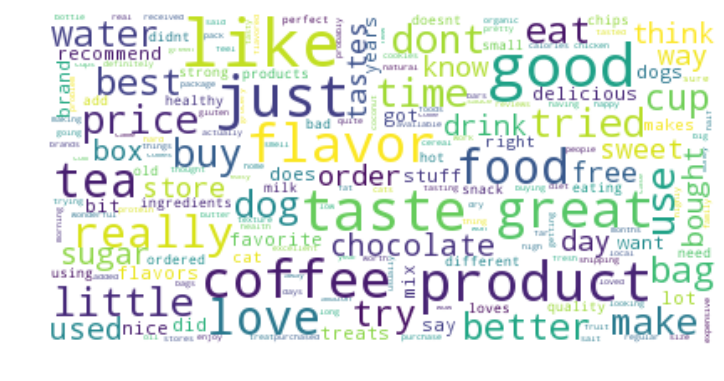

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

## Extract features from cvec.
features = np.array(cvec.get_feature_names())

## Count features.
feature_counts = np.array(cmat.sum(axis=0)).squeeze()

## Construct token-count dictionary.
token_counts = dict()
for feature, feature_count in zip(features, feature_counts):
    token_counts[feature] = feature_count
    
## Initialize and generate wordcloud from token-counts.
wordcloud = WordCloud(background_color='white', 
                      max_font_size=40).generate_from_frequencies(token_counts)
    
## Generate 
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Visualize the distribution of token frequency/ratio in the dataset.

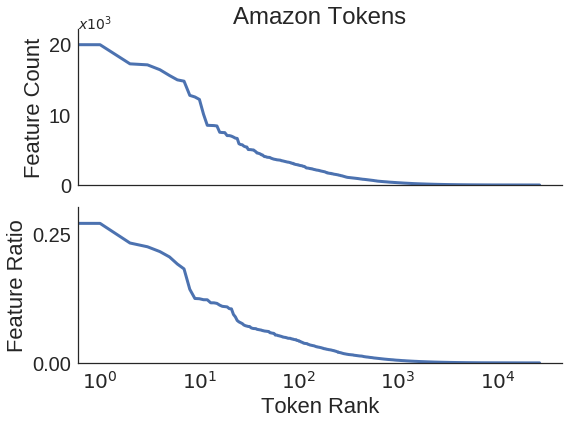

In [3]:
## Plot
fig, axes = plt.subplots(2,1,figsize=(8,6), sharex=True)

## Compute arrays.
feature_counts = np.array( cmat.sum(axis=0) ).squeeze()
feature_ratios = np.array( (cmat > 0).mean(axis=0) ).squeeze()

## Iteratively plot.
for ax, arr in zip(axes, [feature_counts * 1e-3, feature_ratios]):
    ax.plot( np.sort( arr )[::-1], linewidth=3 )
    ax.set(xscale='log')
    
## Fix axes.
axes[0].set(title='Amazon Tokens', ylim=(0,22), yticks=np.linspace(0,20,3), ylabel='Feature Count')
axes[0].annotate(r"$x10^3$", xy=(0.6, 22), fontsize=14)
axes[1].set(xlabel='Token Rank', ylim=(0,0.3), yticks=np.linspace(0,1,5), ylabel='Feature Ratio')

sns.despine()
plt.tight_layout()

### Recount tokens removing singletons and reduce to tokens only appearing 5% or fewer documents.

In [4]:
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

## Initialize CountVectorizer specifying files as inputs.
cvec = CountVectorizer(input='content', max_df=0.05, min_df=2)

## Define all file paths.
filepath = os.path.join('amazon','reviews_tokenized.txt')

## Fit to tokens.
cvec_fit = cvec.fit(open(filepath, 'r').readlines())
cmat = cvec_fit.fit_transform(open(filepath, 'r').readlines())

## Extract features from cvec.
features = np.array(cvec.get_feature_names())

### Rescale the feature-frequency matrix using TfidfTransformer.

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer

## Initialize TfidfTransformer.
transformer = TfidfTransformer( )

## Apply to sparse CountVec matrix.
tfidf_mat = transformer.fit_transform(cmat)
tfidf_mat

<56781x18528 sparse matrix of type '<class 'numpy.float64'>'
	with 1186049 stored elements in Compressed Sparse Row format>

### Using the the multinomial Naive Bayes classifier and 5-fold cross-validation, find which alpha level seems to generate the best scores.

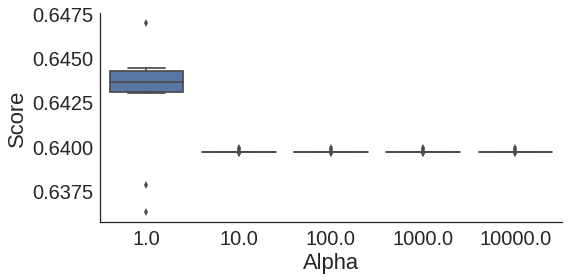

In [6]:
from pandas import DataFrame
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold, cross_val_score

## Read in scores.
scores = np.loadtxt(os.path.join('amazon','scores_tokenized.txt'))

## Define data.
X = tfidf_mat
y = scores

## Initialize cross-validation method.
n_splits = 10
kfold = StratifiedKFold(n_splits=n_splits, random_state=0)

## Define alpha levels.
alphas = np.power(10., np.arange(5))
n_alphas = len(alphas)

## Main loop.
scores = np.empty((n_splits,n_alphas))
for n, alpha in enumerate(alphas):
    
    ## Initialize Lasso.
    mnb = MultinomialNB(alpha=alpha)
    
    ## Compute scores.
    scores[:,n] = cross_val_score(mnb, X, y, cv=kfold)
    

## Turn into DataFrame. Melt.
df = DataFrame(scores, columns=alphas)
df = df.melt(var_name = 'Alpha', value_name = 'Score')

## Plot.
sns.factorplot('Alpha', 'Score', data=df, kind='box', size=4, aspect=2);

### Using the determined alpha level, fit a 80/20 split to the data. Find which tokens are most representative of each Amazon rating.

In [7]:
from sklearn.model_selection import train_test_split

## Split data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

## Initialize MultinomialNB
mnb = MultinomialNB(alpha=1)

## Fit model.
mnb_fit = mnb.fit(X_train, y_train)

## Print scores.
print('MultinomialNB train: score = %0.3f' %mnb_fit.score(X_train,y_train))
print('MultinomialNB test: score = %0.3f' %mnb_fit.score(X_test,y_test))

MultinomialNB train: score = 0.646
MultinomialNB test: score = 0.642


In [8]:
## Extract most common features per category.
for n, feature_class in enumerate(mnb_fit.classes_):
    
    ## Get sorted indices of counts.
    ix = np.argsort(mnb_fit.feature_count_[n])[::-1]
    
    ## Print feature class + top 10 features.
    print(feature_class)
    print(', '.join(features[ix][:20]) + '\n' )

1.0
bad, money, disappointed, received, thought, tasted, item, away, reviews, dogs, waste, purchased, old, ingredients, awful, buying, products, smell, horrible, package

2.0
disappointed, thought, bad, strong, weak, hard, bitter, package, tasted, chips, reviews, maybe, going, away, received, sure, cups, purchased, old, smell

3.0
bad, strong, thought, pretty, probably, sure, ingredients, chips, maybe, hot, regular, liked, quite, stars, mix, disappointed, looking, dogs, bags, isnt

4.0
pretty, strong, snack, stars, tasty, size, dogs, chips, quite, add, easy, hot, treats, milk, enjoy, perfect, sure, regular, fresh, probably

5.0
perfect, snack, treats, dogs, chips, wonderful, happy, cookies, easy, mix, hot, excellent, enjoy, stores, fresh, treat, highly, strong, local, add

